## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

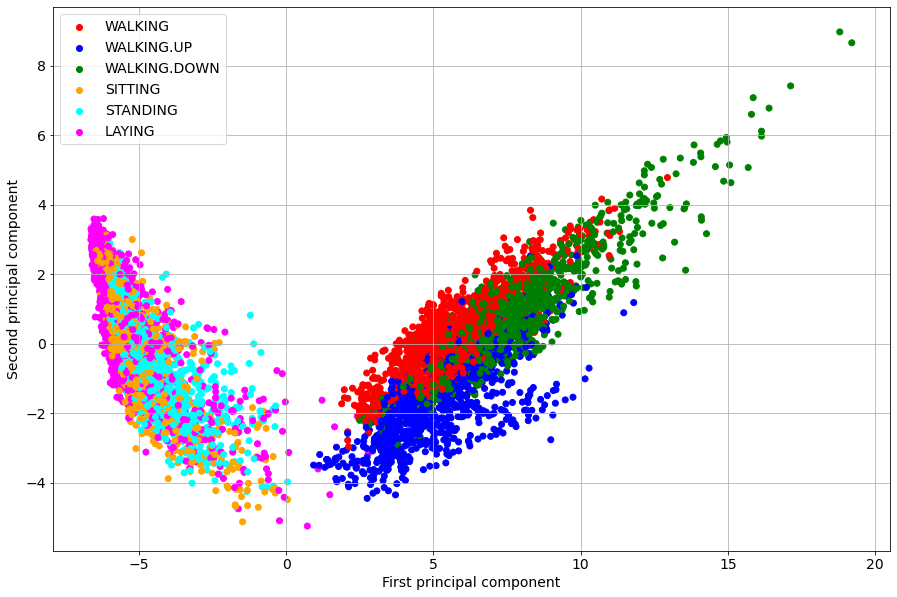

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Experiments start here

In [137]:
import torch
import torch, torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import clear_output
from torch import cuda

In [138]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [139]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.clip_grad as clip_grad

from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import time

In [205]:
N_EPOCHES = 100
BATCH_SIZE = 64
N_LAYERS = 1

Функции для сохранения и загрузки весов модели и оптимизатора

In [206]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

Класс датасета, для получения данных

In [386]:
class UCIHAR(Dataset):
    """ UCI HAR dataset
    
        Returns (X, y) sample, where y is one-hot vector
    """
    def __init__(self, X, y, channel_first=True):
        self.X = X
        self.y = y
        
        if channel_first:
            self.X = self.X.transpose(0, 1, 2)  # [Batch, Timesteps, Channels]
            self._n_timesteps = self.X.shape[-1]
            self._n_features = self.X.shape[1]
        else:
            self._n_timesteps = self.X.shape[1]
            self._n_features = self.X.shape[-1]

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float), torch.tensor(self.y[index], dtype=torch.long)

In [387]:
train_dataset = UCIHAR(X_train, y_train)
test_dataset = UCIHAR(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [429]:
class LSTMModel(nn.Module):
    def __init__(self, n_input=9, n_hidden=n_hidden, n_layers=N_LAYERS,
                n_classes=n_classes, drop_prod=0):
        super(self.__class__, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.drop_prob = drop_prod
        
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True, dropout=drop_prod)
        self.hid_to_logits = nn.Linear(n_hidden, n_classes)
        self.dropuot = nn.Dropout(drop_prod)
        
        nn.init.xavier_uniform_(self.hid_to_logits.weight)
        nn.init.zeros_(self.hid_to_logits.bias)
    
    def forward(self, x, state_h, state_c):
        state = (state_h, state_c)
        lstm_out, state = self.lstm(x, state)
        next_logits = self.hid_to_logits(lstm_out[:, -1])
        next_logp = F.log_softmax(next_logits, dim=1)
        return next_logp, state[0], state[1]
    
    def predict(self, x):
        state = self.initial_state()
        probs, _, _ = self.forward(x, state[0], state[1])
        return probs.max(1)[1].data
        
    def initial_state(self, batch_size=BATCH_SIZE):
        return (torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device),
                torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device)
               )

In [430]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    """
    Function to plot training, validation losses and validation accuracy.
    
    Params:
        train_loss - list, or 1D numpy array with loss values by epoches
        val_loss - list, or 1D numpy array with loss values by epoches
        val_accuracy - list, or 1D numpy array with accuracy values by epoches
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    print(f'Max accurasy score: {max(val_accuracy)} at {np.argmax(val_accuracy)} epoch')
    
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    axes[1].plot(np.argmax(val_accuracy), max(val_accuracy), 'ro')

In [431]:
def eval(model, criterion, test_loader):
    ep_val_loss = []
    ep_val_accuracy = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            if (len(X_batch)==BATCH_SIZE):

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                state_h, state_c = model.initial_state()

                log_probs, _, _ = model(X_batch, state_h.detach(), state_c.detach())

                loss = criterion(log_probs.contiguous(), y_batch[:, 0].contiguous())

                ep_val_loss.append(loss.item())
                y_pred = model.predict(X_batch)
                ep_val_accuracy.append(accuracy_score(y_batch.cpu().numpy(), y_pred.cpu().numpy()))
                
    print(f"\tvalidation loss: {np.mean(ep_val_loss):.6f}")
    print(f"\tvalidation accuracy: {np.mean(ep_val_accuracy):.3f}")
    
    return np.mean(ep_val_loss), np.mean(ep_val_accuracy)

In [432]:
def train_model(model, opt, criterion, train_loader, test_loader, n_epochs=N_EPOCHES, clip_val=15):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    best_accuracy = 0
    
    for epoch in tqdm(range(n_epochs)):        
        start_time = time.time()
            
        model.train(True)
        
        ep_train_loss = []
        
        state_h, state_c = model.initial_state()
        for X_batch, y_batch in train_loader:
            if (len(X_batch)==BATCH_SIZE):
                opt.zero_grad()

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                # Detach hidden state to avoid recomputing of the graph
                log_probs, state_h, state_c = model(X_batch, state_h.detach(), state_c.detach())

                loss = criterion(log_probs.contiguous(), y_batch[:, 0].contiguous())

                loss.backward()

                clip_grad.clip_grad_norm_(model.parameters(), clip_val)

                opt.step()

                ep_train_loss.append(loss.item())

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        print(f"\t  training loss: {np.mean(ep_train_loss):.6f}")
        
        ep_val_loss, ep_val_accuracy = eval(model, criterion, test_loader)
        
        train_loss_history.append(np.mean(ep_train_loss))
        val_loss_history.append(ep_val_loss)
        val_accuracy_history.append(ep_val_accuracy)
        
        if best_accuracy <= ep_val_accuracy:
            best_accuracy = ep_val_accuracy
            save_checkpoint(f'./Lab2_part4_LSTM/best_lstm_{best_accuracy:.3f}_accuracy.pth', model, opt)
        
        if ((epoch+1)%50 == 0):
            plot_train_process(train_loss_history, val_loss_history, val_accuracy_history)
    
    return train_loss_history, val_loss_history, val_accuracy_history

In [433]:
model = LSTMModel().to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss().to(device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100 took 1.067s
	  training loss: 1.609251
	validation loss: 1.391226
	validation accuracy: 0.412
model saved to ./Lab2_part4_LSTM/best_lstm_0.412_accuracy.pth
Epoch 2 of 100 took 0.876s
	  training loss: 1.248072
	validation loss: 1.225892
	validation accuracy: 0.477
model saved to ./Lab2_part4_LSTM/best_lstm_0.477_accuracy.pth
Epoch 3 of 100 took 0.831s
	  training loss: 1.143709
	validation loss: 1.188809
	validation accuracy: 0.505
model saved to ./Lab2_part4_LSTM/best_lstm_0.505_accuracy.pth
Epoch 4 of 100 took 0.831s
	  training loss: 1.063114
	validation loss: 1.127000
	validation accuracy: 0.567
model saved to ./Lab2_part4_LSTM/best_lstm_0.567_accuracy.pth
Epoch 5 of 100 took 0.946s
	  training loss: 0.956614
	validation loss: 1.071701
	validation accuracy: 0.579
model saved to ./Lab2_part4_LSTM/best_lstm_0.579_accuracy.pth
Epoch 6 of 100 took 0.897s
	  training loss: 0.855785
	validation loss: 0.864691
	validation accuracy: 0.692
model saved to ./Lab2_part4_LSTM/bes

Epoch 62 of 100 took 0.904s
	  training loss: 0.142577
	validation loss: 0.409511
	validation accuracy: 0.896
Epoch 63 of 100 took 0.923s
	  training loss: 0.127993
	validation loss: 0.441165
	validation accuracy: 0.898
Epoch 64 of 100 took 0.917s
	  training loss: 0.155920
	validation loss: 0.379952
	validation accuracy: 0.903
model saved to ./Lab2_part4_LSTM/best_lstm_0.903_accuracy.pth
Epoch 65 of 100 took 0.919s
	  training loss: 0.135478
	validation loss: 0.375536
	validation accuracy: 0.893
Epoch 66 of 100 took 0.880s
	  training loss: 0.136159
	validation loss: 0.361568
	validation accuracy: 0.892
Epoch 67 of 100 took 0.911s
	  training loss: 0.131716
	validation loss: 0.414374
	validation accuracy: 0.886
Epoch 68 of 100 took 0.856s
	  training loss: 0.122617
	validation loss: 0.363832
	validation accuracy: 0.897
Epoch 69 of 100 took 0.866s
	  training loss: 0.117377
	validation loss: 0.349561
	validation accuracy: 0.897
Epoch 70 of 100 took 0.854s
	  training loss: 0.123416
	va

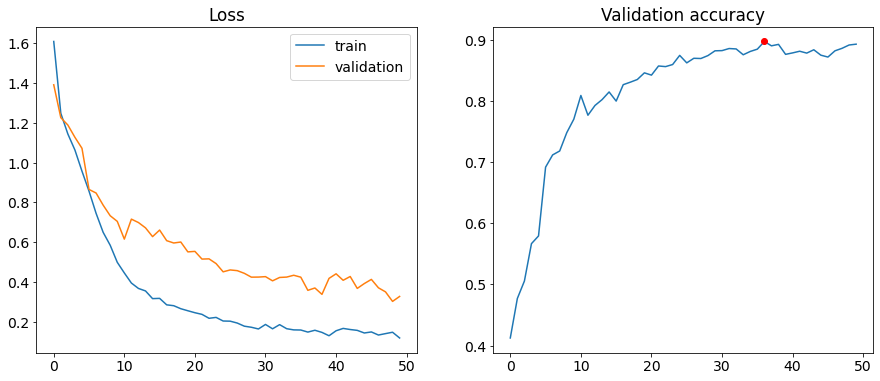

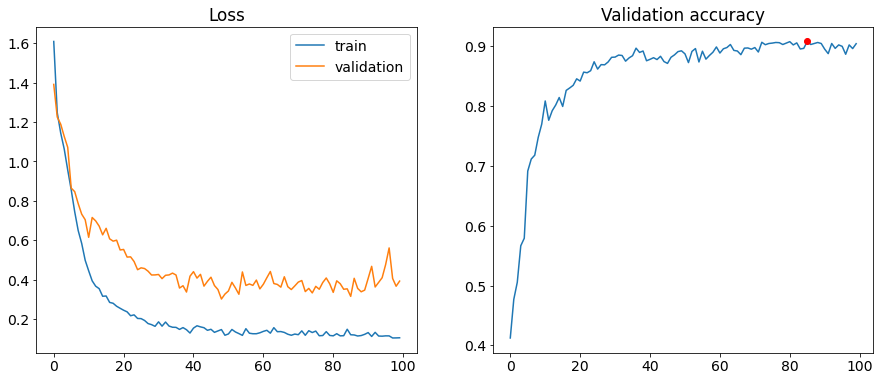

In [434]:
train_loss, val_loss, val_accuracy = train_model(model, opt, criterion, train_dataloader, test_dataloader, 100, 5)

#### Оно работает, но давайте попробуем несколько вещей

1) Будем брать не последний выход из LSTM, а последний после линейного преобразования

*Итог:* Если брать последний выход через прогон после softmax, получается что-то крайне неустойчивое, однако если брать последний после прогона линейного рпеобразования, то разницы нет

In [443]:
class LSTMModelTest(nn.Module):
    def __init__(self, n_input=9, n_hidden=n_hidden, n_layers=N_LAYERS,
                n_classes=n_classes, drop_prod=0):
        super(self.__class__, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.drop_prob = drop_prod
        
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True, dropout=drop_prod)
        self.hid_to_logits = nn.Linear(n_hidden, n_classes)
        self.dropuot = nn.Dropout(drop_prod)
        
        nn.init.xavier_uniform_(self.hid_to_logits.weight)
        nn.init.zeros_(self.hid_to_logits.bias)
    
    def forward(self, x, state_h, state_c):
        state = (state_h, state_c)
        lstm_out, state = self.lstm(x, state)
        next_logits = self.hid_to_logits(lstm_out)
        next_logp = F.log_softmax(next_logits[:, -1], dim=1)
        return next_logp, state[0], state[1]
    
    def predict(self, x):
        state = self.initial_state()
        probs, _, _ = self.forward(x, state[0], state[1])
        return probs.max(1)[1].data
        
    def initial_state(self, batch_size=BATCH_SIZE):
        return (torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device),
                torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device)
               )

In [444]:
model_test = LSTMModelTest().to(device)
opt = torch.optim.Adam(model_test.parameters())
criterion = nn.NLLLoss().to(device)

In [445]:
batch = next(iter(train_dataloader))
X_batch, y_batch = batch[0].to(device), batch[1].to(device)

In [446]:
state_h, state_c = model_test.initial_state()

In [447]:
with torch.no_grad():
    model(X_batch, state_h, state_c)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100 took 1.189s
	  training loss: 1.624594
	validation loss: 1.417015
	validation accuracy: 0.371
model saved to ./Lab2_part4_LSTM/best_lstm_0.371_accuracy.pth
Epoch 2 of 100 took 0.880s
	  training loss: 1.276090
	validation loss: 1.241708
	validation accuracy: 0.490
model saved to ./Lab2_part4_LSTM/best_lstm_0.490_accuracy.pth
Epoch 3 of 100 took 0.977s
	  training loss: 1.148428
	validation loss: 1.201607
	validation accuracy: 0.497
model saved to ./Lab2_part4_LSTM/best_lstm_0.497_accuracy.pth
Epoch 4 of 100 took 0.855s
	  training loss: 1.078156
	validation loss: 1.176892
	validation accuracy: 0.483
Epoch 5 of 100 took 0.933s
	  training loss: 1.055183
	validation loss: 1.132509
	validation accuracy: 0.519
model saved to ./Lab2_part4_LSTM/best_lstm_0.519_accuracy.pth
Epoch 6 of 100 took 0.933s
	  training loss: 0.963991
	validation loss: 0.954426
	validation accuracy: 0.607
model saved to ./Lab2_part4_LSTM/best_lstm_0.607_accuracy.pth
Epoch 7 of 100 took 0.886s
	  traini

	validation loss: 0.504463
	validation accuracy: 0.881
Epoch 59 of 100 took 0.924s
	  training loss: 0.137783
	validation loss: 0.527351
	validation accuracy: 0.881
Epoch 60 of 100 took 0.877s
	  training loss: 0.142343
	validation loss: 0.358074
	validation accuracy: 0.907
model saved to ./Lab2_part4_LSTM/best_lstm_0.907_accuracy.pth
Epoch 61 of 100 took 0.904s
	  training loss: 0.122108
	validation loss: 0.383255
	validation accuracy: 0.901
Epoch 62 of 100 took 0.939s
	  training loss: 0.138375
	validation loss: 0.464655
	validation accuracy: 0.890
Epoch 63 of 100 took 0.887s
	  training loss: 0.141810
	validation loss: 0.509562
	validation accuracy: 0.885
Epoch 64 of 100 took 0.898s
	  training loss: 0.130226
	validation loss: 0.347242
	validation accuracy: 0.905
Epoch 65 of 100 took 0.914s
	  training loss: 0.116378
	validation loss: 0.317404
	validation accuracy: 0.906
Epoch 66 of 100 took 0.922s
	  training loss: 0.152244
	validation loss: 0.355244
	validation accuracy: 0.903
Epo

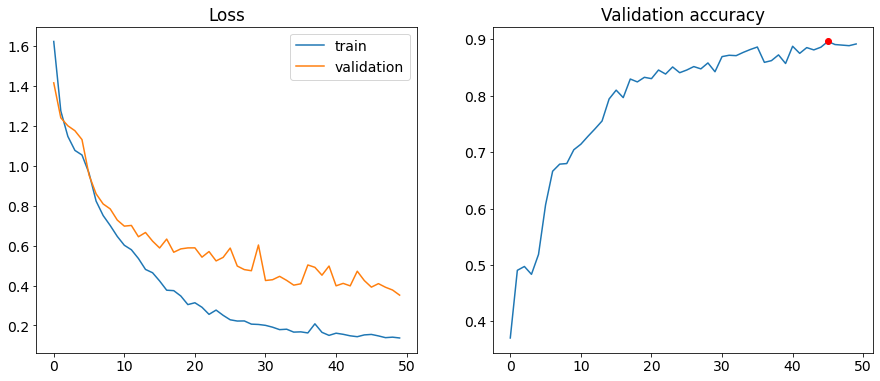

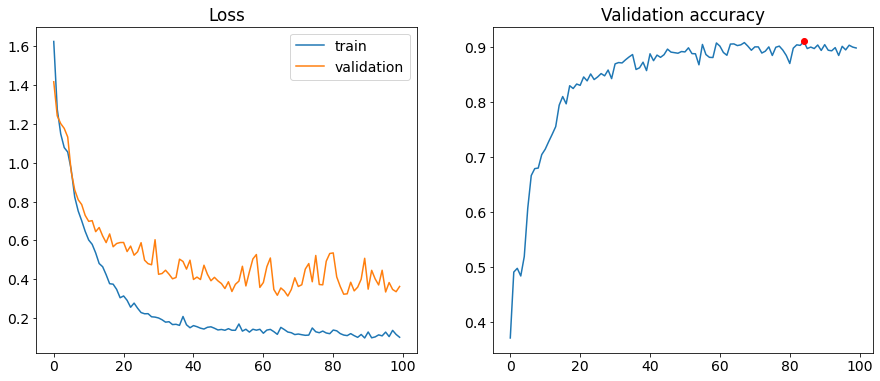

In [448]:
train_loss, val_loss, val_accuracy = train_model(model_test, opt, criterion, train_dataloader, test_dataloader, 100, 5)

2) Побробует на посылать в модель hidden state явно

*Итог:* модель выдает такие же результаты, как и при явном передавании state'ов

In [449]:
class LSTMModelTest_2(nn.Module):
    def __init__(self, n_input=9, n_hidden=n_hidden, n_layers=N_LAYERS,
                n_classes=n_classes, drop_prod=0):
        super(self.__class__, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.drop_prob = drop_prod
        
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True, dropout=drop_prod)
        self.hid_to_logits = nn.Linear(n_hidden, n_classes)
        self.dropuot = nn.Dropout(drop_prod)
        
        nn.init.xavier_uniform_(self.hid_to_logits.weight)
        nn.init.zeros_(self.hid_to_logits.bias)
    
    def forward(self, x):
        state = self.initial_state()
        lstm_out, _ = self.lstm(x, state)
        next_logits = self.hid_to_logits(lstm_out)
        next_logp = F.log_softmax(next_logits[:, -1], dim=1)
        return next_logp
    
    def predict(self, x):
        probs = self.forward(x)
        return probs.max(1)[1].data
        
    def initial_state(self, batch_size=BATCH_SIZE):
        return (torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device),
                torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device)
               )

In [450]:
def eval_test_2(model, criterion, test_loader):
    ep_val_loss = []
    ep_val_accuracy = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            if (len(X_batch)==BATCH_SIZE):

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                

                log_probs = model(X_batch)

                loss = criterion(log_probs.contiguous(), y_batch[:, 0].contiguous())

                ep_val_loss.append(loss.item())
                y_pred = model.predict(X_batch)
                ep_val_accuracy.append(accuracy_score(y_batch.cpu().numpy(), y_pred.cpu().numpy()))
                
    print(f"\tvalidation loss: {np.mean(ep_val_loss):.6f}")
    print(f"\tvalidation accuracy: {np.mean(ep_val_accuracy):.3f}")
    
    return np.mean(ep_val_loss), np.mean(ep_val_accuracy)

In [451]:
def train_model_test2(model, opt, criterion, train_loader, test_loader, n_epochs=N_EPOCHES, clip_val=15):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    best_accuracy = 0
    
    for epoch in tqdm(range(n_epochs)):        
        start_time = time.time()
            
        model.train(True)
        
        ep_train_loss = []
        
        for X_batch, y_batch in train_loader:
            if (len(X_batch)==BATCH_SIZE):
                opt.zero_grad()

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                # Detach hidden state to avoid recomputing of the graph
                log_probs = model(X_batch)

                loss = criterion(log_probs.contiguous(), y_batch[:, 0].contiguous())

                loss.backward()

                clip_grad.clip_grad_norm_(model.parameters(), clip_val)

                opt.step()

                ep_train_loss.append(loss.item())

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        print(f"\t  training loss: {np.mean(ep_train_loss):.6f}")
        
        ep_val_loss, ep_val_accuracy = eval_test_2(model, criterion, test_loader)
        
        train_loss_history.append(np.mean(ep_train_loss))
        val_loss_history.append(ep_val_loss)
        val_accuracy_history.append(ep_val_accuracy)
        
        if best_accuracy <= ep_val_accuracy:
            best_accuracy = ep_val_accuracy
            save_checkpoint(f'./Lab2_part4_LSTM/best_lstm_{best_accuracy:.3f}_accuracy.pth', model, opt)
        
        if ((epoch+1)%100 == 0):
            plot_train_process(train_loss_history, val_loss_history, val_accuracy_history)
    
    return train_loss_history, val_loss_history, val_accuracy_history

In [455]:
model_test_2 = LSTMModelTest_2().to(device)
opt = torch.optim.Adam(model_test_2.parameters())
criterion = nn.NLLLoss().to(device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100 took 1.864s
	  training loss: 1.627710
	validation loss: 1.390700
	validation accuracy: 0.367
model saved to ./Lab2_part4_LSTM/best_lstm_0.367_accuracy.pth
Epoch 2 of 100 took 1.597s
	  training loss: 1.250502
	validation loss: 1.239390
	validation accuracy: 0.464
model saved to ./Lab2_part4_LSTM/best_lstm_0.464_accuracy.pth
Epoch 3 of 100 took 1.645s
	  training loss: 1.138819
	validation loss: 1.232427
	validation accuracy: 0.485
model saved to ./Lab2_part4_LSTM/best_lstm_0.485_accuracy.pth
Epoch 4 of 100 took 1.636s
	  training loss: 1.088185
	validation loss: 1.165674
	validation accuracy: 0.549
model saved to ./Lab2_part4_LSTM/best_lstm_0.549_accuracy.pth
Epoch 5 of 100 took 1.658s
	  training loss: 1.015132
	validation loss: 1.021832
	validation accuracy: 0.567
model saved to ./Lab2_part4_LSTM/best_lstm_0.567_accuracy.pth
Epoch 6 of 100 took 1.617s
	  training loss: 0.898397
	validation loss: 0.855269
	validation accuracy: 0.660
model saved to ./Lab2_part4_LSTM/bes

Epoch 61 of 100 took 1.620s
	  training loss: 0.137171
	validation loss: 0.370172
	validation accuracy: 0.897
Epoch 62 of 100 took 1.679s
	  training loss: 0.142469
	validation loss: 0.405922
	validation accuracy: 0.894
Epoch 63 of 100 took 1.632s
	  training loss: 0.135249
	validation loss: 0.332772
	validation accuracy: 0.902
Epoch 64 of 100 took 1.622s
	  training loss: 0.126843
	validation loss: 0.354187
	validation accuracy: 0.904
Epoch 65 of 100 took 1.610s
	  training loss: 0.120490
	validation loss: 0.360371
	validation accuracy: 0.905
model saved to ./Lab2_part4_LSTM/best_lstm_0.905_accuracy.pth
Epoch 66 of 100 took 1.653s
	  training loss: 0.119894
	validation loss: 0.358896
	validation accuracy: 0.907
model saved to ./Lab2_part4_LSTM/best_lstm_0.907_accuracy.pth
Epoch 67 of 100 took 1.651s
	  training loss: 0.119377
	validation loss: 0.383851
	validation accuracy: 0.905
Epoch 68 of 100 took 1.634s
	  training loss: 0.135602
	validation loss: 0.363425
	validation accuracy: 0.

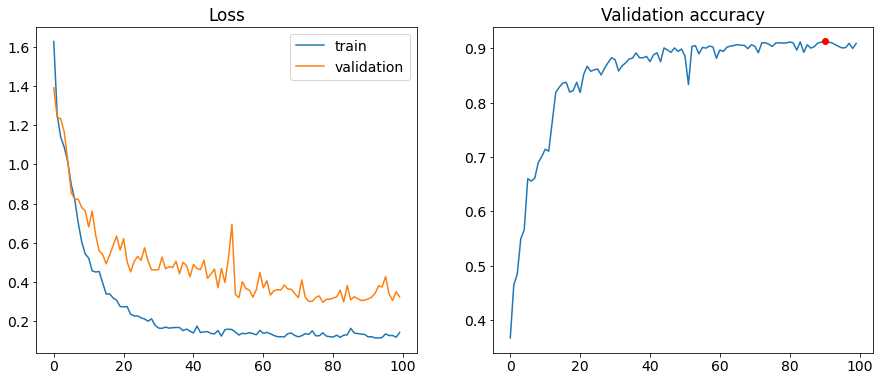

In [456]:
train_loss, val_loss, val_accuracy = train_model_test2(model_test_2,
                                                       opt,
                                                       criterion,
                                                       train_dataloader,
                                                       test_dataloader,
                                                       n_epochs=100,
                                                       clip_val=5)

3) Попробуем вариант, но с CrossEntropyLoss

*Итог:* теряется точность, из-за точности вычислений log и exp

In [503]:
class LSTMModelTest_3(nn.Module):
    def __init__(self, n_input=9, n_hidden=n_hidden, n_layers=N_LAYERS,
                n_classes=n_classes, drop_prod=0):
        super(self.__class__, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.drop_prob = drop_prod
        
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True, dropout=drop_prod)
        self.hid_to_logits = nn.Linear(n_hidden, n_classes)
        self.dropuot = nn.Dropout(drop_prod)
        
        nn.init.xavier_uniform_(self.hid_to_logits.weight)
        nn.init.zeros_(self.hid_to_logits.bias)
    
    def forward(self, x):
        state = self.initial_state()
        lstm_out, state = self.lstm(x, state)
        next_logits = self.hid_to_logits(lstm_out[:, 1])
        return next_logits
    
    def predict(self, x):
        logits = self.forward(x)
        probs = F.softmax(logits, dim=-1)
        return probs.argmax(dim=-1).data
        
    def initial_state(self, batch_size=BATCH_SIZE):
        return (torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device),
                torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device)
               )

In [504]:
def eval_test_3(model, criterion, test_loader):
    ep_val_loss = []
    ep_val_accuracy = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            if (len(X_batch)==BATCH_SIZE):

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                

                log_probs = model(X_batch)

                loss = criterion(log_probs.contiguous(), y_batch[:, 0].contiguous())

                ep_val_loss.append(loss.item())
                y_pred = model.predict(X_batch)
                ep_val_accuracy.append(accuracy_score(y_batch.cpu().numpy(), y_pred.cpu().numpy()))
                
    print(f"\tvalidation loss: {np.mean(ep_val_loss):.6f}")
    print(f"\tvalidation accuracy: {np.mean(ep_val_accuracy):.3f}")
    
    return np.mean(ep_val_loss), np.mean(ep_val_accuracy)

In [505]:
def train_model_test3(model, opt, criterion, train_loader, test_loader, n_epochs=N_EPOCHES, clip_val=15):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    best_accuracy = 0
    
    for epoch in tqdm(range(n_epochs)):        
        start_time = time.time()
            
        model.train(True)
        
        ep_train_loss = []
        
        for X_batch, y_batch in train_loader:
            if (len(X_batch)==BATCH_SIZE):
                opt.zero_grad()

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                log_probs = model(X_batch)

                loss = criterion(log_probs.contiguous(), y_batch[:, 0].contiguous())

                loss.backward()

                clip_grad.clip_grad_norm_(model.parameters(), clip_val)

                opt.step()

                ep_train_loss.append(loss.item())

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        print(f"\t  training loss: {np.mean(ep_train_loss):.6f}")
        
        ep_val_loss, ep_val_accuracy = eval_test_3(model, criterion, test_loader)
        
        train_loss_history.append(np.mean(ep_train_loss))
        val_loss_history.append(ep_val_loss)
        val_accuracy_history.append(ep_val_accuracy)
        
        if best_accuracy <= ep_val_accuracy:
            best_accuracy = ep_val_accuracy
            save_checkpoint(f'./Lab2_part4_LSTM/best_lstm_{best_accuracy:.3f}_accuracy.pth', model, opt)
        
        if ((epoch+1)%50 == 0):
            plot_train_process(train_loss_history, val_loss_history, val_accuracy_history)
    
    return train_loss_history, val_loss_history, val_accuracy_history

In [506]:
model_test_3 = LSTMModelTest_3().to(device)
opt = torch.optim.Adam(model_test_3.parameters())
criterion = nn.CrossEntropyLoss().to(device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100 took 1.804s
	  training loss: 1.753639
	validation loss: 1.705066
	validation accuracy: 0.430
model saved to ./Lab2_part4_LSTM/best_lstm_0.430_accuracy.pth
Epoch 2 of 100 took 1.505s
	  training loss: 1.567933
	validation loss: 1.455390
	validation accuracy: 0.435
model saved to ./Lab2_part4_LSTM/best_lstm_0.435_accuracy.pth
Epoch 3 of 100 took 1.522s
	  training loss: 1.306263
	validation loss: 1.280321
	validation accuracy: 0.481
model saved to ./Lab2_part4_LSTM/best_lstm_0.481_accuracy.pth
Epoch 4 of 100 took 1.545s
	  training loss: 1.172426
	validation loss: 1.202897
	validation accuracy: 0.522
model saved to ./Lab2_part4_LSTM/best_lstm_0.522_accuracy.pth
Epoch 5 of 100 took 1.579s
	  training loss: 1.100156
	validation loss: 1.160877
	validation accuracy: 0.529
model saved to ./Lab2_part4_LSTM/best_lstm_0.529_accuracy.pth
Epoch 6 of 100 took 1.531s
	  training loss: 1.050944
	validation loss: 1.128272
	validation accuracy: 0.538
model saved to ./Lab2_part4_LSTM/bes

Epoch 49 of 100 took 1.535s
	  training loss: 0.530010
	validation loss: 0.718120
	validation accuracy: 0.713
model saved to ./Lab2_part4_LSTM/best_lstm_0.713_accuracy.pth
Epoch 50 of 100 took 1.507s
	  training loss: 0.527901
	validation loss: 0.716683
	validation accuracy: 0.715
model saved to ./Lab2_part4_LSTM/best_lstm_0.715_accuracy.pth
Max accurasy score: 0.7150135869565217 at 49 epoch
Epoch 51 of 100 took 1.614s
	  training loss: 0.525823
	validation loss: 0.715295
	validation accuracy: 0.714
Epoch 52 of 100 took 1.617s
	  training loss: 0.523774
	validation loss: 0.713955
	validation accuracy: 0.716
model saved to ./Lab2_part4_LSTM/best_lstm_0.716_accuracy.pth
Epoch 53 of 100 took 1.518s
	  training loss: 0.521753
	validation loss: 0.712661
	validation accuracy: 0.717
model saved to ./Lab2_part4_LSTM/best_lstm_0.717_accuracy.pth
Epoch 54 of 100 took 1.495s
	  training loss: 0.519759
	validation loss: 0.711413
	validation accuracy: 0.715
Epoch 55 of 100 took 1.522s
	  training l

Epoch 100 of 100 took 1.552s
	  training loss: 0.450452
	validation loss: 0.684114
	validation accuracy: 0.736
Max accurasy score: 0.7360733695652174 at 97 epoch


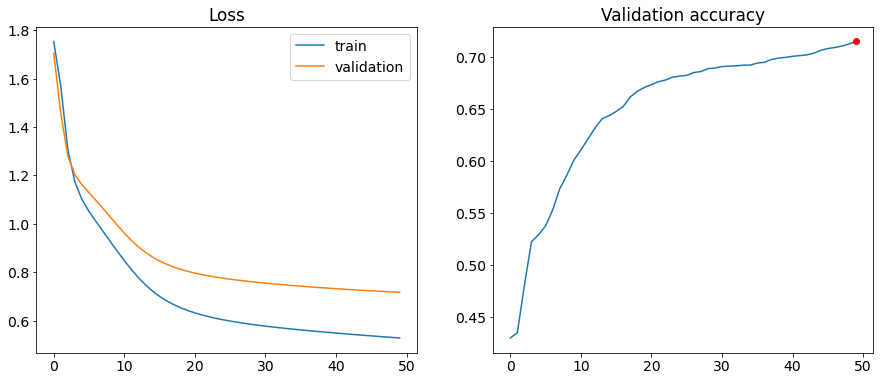

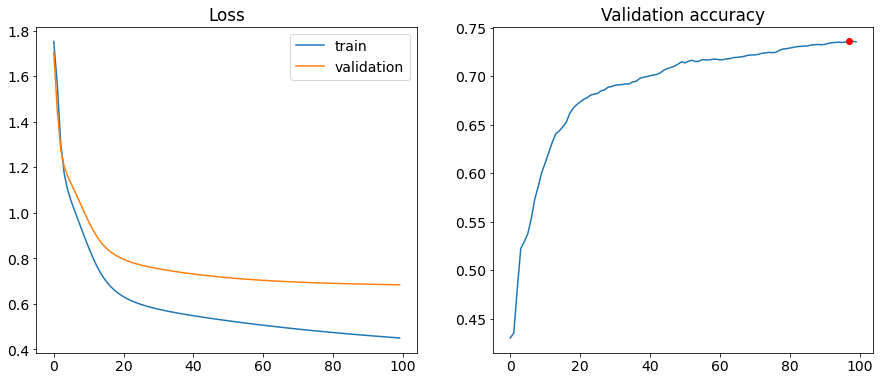

In [507]:
train_loss, val_loss, val_accuracy = train_model_test3(model_test_3,
                                                       opt,
                                                       criterion,
                                                       train_dataloader,
                                                       test_dataloader,
                                                       n_epochs=100,
                                                       clip_val=5)

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
# Your experiments here